In [ ]:

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool

from langchain_google_genai import ChatGoogleGenerativeAI  
from langchain_google_genai import GoogleGenerativeAIEmbeddings  

from langchain_chroma import Chroma, vectorstores
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os


print("✅ All imports successful")

✅ All imports successful


In [35]:
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY2")
if not api_key:
    raise ValueError("GOOGLE_API_KEY not set in environment!")

print("✅ Environment variables loaded")

✅ Environment variables loaded


In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  
    api_key=api_key,
    temperature=0.3,
)
print(f"✅ LLM initialized: {llm.model}")

✅ LLM initialized: gemini-2.5-flash


## Loading and Chunking DOcument 

In [4]:
loaders = [
    PyPDFLoader("data/Ebook of Tax Related Law.pdf"),
    PyPDFLoader("data/Nigeria-Tax-Act-2025.pdf"),
    PyPDFLoader("data/nigeria-tax-reform-insight-series-sectoral-analysis.pdf"),
    PyPDFLoader("data/Taxation_by_ICAN.pdf"),
    PyPDFLoader("data/The Nigeria Tax Act (NTA), 2025 Explained.pdf"),
]

documents = []
for loader in loaders:
    documents.extend(loader.load())


## Document Chunking

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=250,
    separators=["\n\n", "\n", ".", ";"]
)

doc_chunks = text_splitter.split_documents(documents)

print(f"✅ Loaded and split {len(doc_chunks)} document chunks")

✅ Loaded and split 3553 document chunks


## Embedding 

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

print("✅ HuggingFace embeddings loaded")


## Vector Storage

In [8]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = Chroma(
    collection_name="my_documents",
    embedding_function=embeddings,
    persist_directory="./chroma_db"
)


In [76]:
# vectorstore.add_documents(doc_chunks)

## Retrieval Tool

In [64]:
from langchain_core.tools import tool


def retrieve_tax_law(query: str) -> str:
    """
    Retrieve relevant sections from Nigerian tax law and related authoritative documents.
    Use for legal interpretation, definitions, compliance, rates, obligations, or history.
    """
    docs = vectorstore.max_marginal_relevance_search(
        query,
        k=5,
        fetch_k=15
    )

    context = []
    for d in docs:
        source = d.metadata.get("source", "Unknown Source")
        page = d.metadata.get("page", "N/A")

        context.append(
            f"Source: {source} | Page: {page}\n{d.page_content}"
        )

    return "\n\n".join(context)

tools = [retrieve_tax_law]
tool_node = ToolNode(tools)


## Agent System Prompt

In [65]:
from langgraph.graph import MessagesState

SYSTEM_PROMPT = """
You are a Nigerian tax law assistant.

Rules:
- Remember previous parts of the conversation.
- Use retrieved documents for any legal, historical, or compliance-related questions.
- Do NOT guess legal interpretations.
- When citing law, rely strictly on retrieved text.
- If the question is conceptual (e.g. "What is tax?"), retrieval may be optional.
"""


## Agent Logic

In [ ]:
# --- Assistant node ---
def assistant_node(state: MessagesState):
    messages = state["messages"]

    
    decision_prompt = messages + [
        AIMessage(content="Should legal documents be retrieved to answer this question? Reply ONLY YES or NO.")
    ]
    decision = llm.invoke(decision_prompt).content.strip().upper()


    state["need_docs"] = decision == "YES"

    
    if not state["need_docs"]:
        response = llm.invoke(messages)
        state["last_response"] = response
    return state

In [ ]:
# Assistant with context node 
def assistant_with_context_node(state: MessagesState):
    messages = state["messages"]
    retrieved_docs = state.get("retrieved_docs", "")

    
    context_prompt = messages + [AIMessage(content=f"Context:\n{retrieved_docs}")]
    response = llm.invoke(context_prompt)
    state["last_response"] = response
    return state

# Retrieval wrapper node 
def retrieval_node(state: MessagesState):
    query = state["messages"][-1].content
    retrieved_docs = retrieve_tax_law(query)
    state["retrieved_docs"] = retrieved_docs
    return state


## Build LangGraph

In [ ]:
# Build the graph 
graph = StateGraph(MessagesState)
graph.add_node("assistant", assistant_node)                     
graph.add_node("tools", retrieval_node)                         
graph.add_node("assistant_with_context", assistant_with_context_node)  

graph.add_edge("assistant", "tools")                     
graph.add_edge("assistant", "assistant_with_context")    
graph.add_edge("tools", "assistant_with_context")        


graph.set_entry_point("assistant")
app = graph.compile()


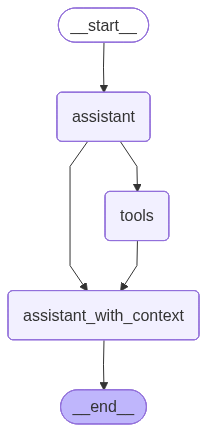

In [70]:
# Visualize the agentic RAG graph
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

## Tool Logic

## Testing the Agent

In [ ]:
def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Improved query function with clearer output.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = app.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    
    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print(f"🔍 Agent: [Calling retrieval tool...]")
            if message.content and not message.tool_calls:
                final_answer = message.content

    # Always print final answer
    if final_answer:
        print(f"🤖 Agent: {final_answer}")
    else:
        print(f"⚠️ No response generated after retrieval!")

    # Summary
    print(f"\n📊 Decision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")



In [50]:
query_agent("What are the new changes in Nigerian tax law?")


👤 User: What are the new changes in Nigerian tax law?



Task assistant with path ('__pregel_pull', 'assistant') wrote to unknown channel branch:to:{'tools': False, 'assistant_with_context': True}, ignoring it.


🤖 Agent: Nigerian tax law has seen several significant changes and developments recently, primarily through new legislation and amendments to existing laws. The most notable include:

1.  **The Finance Act, 2023:** This Act, signed into law on May 28, 2023, introduced amendments to several tax and other laws to support the 2023 Appropriation Act. Key changes include:
    *   **Value Added Tax (VAT):**
        *   VAT is now applicable to the supply of goods and services by companies operating in Nigeria's oil and gas free zones to companies in the customs territory. Previously, such supplies were zero-rated.
        *   The Act clarifies that "goods" include "imported services or other intangibles" and "VATable services" include "imported services or other intangibles."
        *   Non-resident digital companies are now required to charge and collect VAT on services provided to Nigerian customers and remit it to the FIRS.
    *   **Companies Income Tax (CIT):**
        *   It re-introd